In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
p = 'output/2021_Feb_10_19_55_56_PAMBUH/'

In [3]:
import os
import sys
os.chdir('..')
# sys.path.append(p  + 'src')
sys.path.append('src')

In [4]:
from pathlib import Path
from PIL import Image
from functools import partial

import cv2
import numpy as np
import torch
import torch.nn.functional as F
import albumentations as albu
from tqdm.notebook import tqdm
import _data
import augs
import callbacks
import sampler
import model as nn_model
from config import cfg, cfg_init
from postprocessing import read_and_process_img, postprocess_test_folder, _plot_img
from sampler import get_basics_rasterio

import  matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# datasets = data.build_datasets(cfg)
# dls = data.build_dataloaders(cfg, datasets, pin=True, drop_last=False)
# tdl = dls['TRAIN']
# xb,yb = next(iter(tdl))
# xb.shape, yb.shape

# s = sampler.tif_block_read('./input/hm/test/b2dc8411c.tiff')
# _,_,img = next(iter(s))
# img.shape, img.dtype

In [14]:
from utils import get_tiff_block

In [18]:
def parse_model_path(p):
    name = str(p.name)
    epoch = name.split('_')[0]
    return int(epoch[1:])

def get_last_model(src):
    # assumes that model name is of type e500_blabla.pth, sorted by epoch #500
    models = list(Path(src).glob('*.pth'))
    res = []
    for i, m in enumerate(models):
        epoch = parse_model_path(m)
        #print(m, epoch)
        
        res.append([i,epoch])
    idx = sorted(res, key=lambda x: -x[1])[0][0]
    return models[idx]

def rescale(batch_img, scale): return F.interpolate(batch_img, scale_factor=(scale, scale))

def preprocess_image(cfg, img):
    train_trans = augs.get_aug('light', cfg.TRANSFORMERS)
    transform = train_trans.transforms.transforms[-1]
    #print(transform)
    #transform = albu.Compose([albu.Normalize(mean=cfg.TRANSFORMERS.MEAN, std=cfg.TRANSFORMERS.STD)])
    ch, H,W, dtype = *img.shape, img.dtype
    assert ch==3
    assert dtype==np.uint8, dtype
    img = img.transpose(1,2,0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (W//2, H//2))
    return transform(image=img)['image']
    
def _infer_func(imgs, cfg, model):
    batch = []
    for img in imgs:
        batch.append(preprocess_image(cfg, img))
    
    batch = torch.stack(batch,axis=0)
    #print(batch.shape, batch.dtype)
    with torch.no_grad():
        res = torch.sigmoid(model(batch))
    res = rescale(res, 2)
    return res

def get_infer_func(p):
    cfg_init(p + 'cfg.yaml')
    cfg['PARALLEL']['DDP'] = False
    cfg['DATA']['TRAIN']['PRELOAD'] = False
        
    model_path = get_last_model(p + 'models')
    m = nn_model.load_model(cfg, str(model_path))
    
    return partial(_infer_func, cfg=cfg, model=m)

In [19]:
foo = get_infer_func(p)

In [8]:
src_folder = '/mnt/storage/HuBMAP/test/'
img_name = next(Path(src_folder).glob('*.tiff'))
print(img_name)

/mnt/storage/HuBMAP/test/b9a3865fc.tiff


In [34]:
def read_and_process_img(path : str, do_infer, block_size : int = 512, crop_size : int = 500, cuda : bool = True) -> np.ndarray:
    assert block_size >= crop_size, (block_size, crop_size)
    cuda = cuda and torch.cuda.is_available()
    fd, (h, w), channel = get_basics_rasterio(path)
    print(h, w)
    pad = (block_size - crop_size)//2
    rows = []
    -pad, h
    for y in tqdm(range(25000, 27000, crop_size), desc='rows'):
        row, zeros_idx = [], []
        for i, x in enumerate(tqdm(range(-pad, w, crop_size), desc='columns')):
            pad_x = (pad if x < 0 else 0, x + block_size - w if x + block_size > w else 0)
            pad_y = (pad if y < 0 else 0, y + block_size - h if y + block_size > h else 0)
            pad_chw = ((0, 0), pad_y, pad_x)
            block = get_tiff_block(fd, x, y, block_size)
            pad_block = np.pad(block, pad_chw, 'constant', constant_values=0)
            if pad_block.max() > 0:
                row.append(pad_block)
            else:
                zeros_idx.append(i)
        if row:
            nozero_masks = do_infer(row)[:, :, pad:-pad, pad:-pad]
            masks_list = [i.squeeze(0) for i in nozero_masks]
            for i in zeros_idx:
                masks_list.insert(i, torch.zeros((crop_size, crop_size)))
            mask_row = torch.cat(masks_list, 0)
        else:
            mask_row = torch.zeros((crop_size, w))
        rows.append(mask_row)
    mask = np.uint8(torch.cat(rows, 0)[:h, :w]*255)
#     assert mask.shape == (h, w)
    return mask

l = read_and_process_img(img_name, foo, 2048, 2000)
l.shape

31295 40429


rows:   0%|          | 0/1 [00:00<?, ?it/s]

columns:   0%|          | 0/21 [00:00<?, ?it/s]

(31295, 2000)

(31295, 2000)


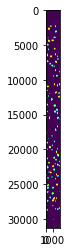

In [35]:
_plot_img(l)

In [146]:
mask = read_and_process_img(img_name, foo, size=2048, crop_size=2000)
mask.shape

(31295, 40429)


rows:   0%|          | 0/65 [00:00<?, ?it/s]

columns:   0%|          | 0/83 [00:00<?, ?it/s]

RuntimeError: stack expects each tensor to be equal size, but got [3, 1024, 1024] at entry 0 and [3, 1024, 1274] at entry 2

(2000, 40429)


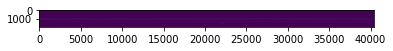

In [144]:
_plot_img(mask)

In [ ]:
postprocess_test_folder(foo, src_folder, './output')

# Tests

## Sampler

In [ ]:
s = sampler.tif_block_read('./input/hm/test/b2dc8411c.tiff', block_size=(1024,1024))
s = iter(s)
_,_,img = next(s)
print(img.shape, img.dtype)

In [ ]:
Image.fromarray(img.transpose(1,2,0)).resize((256,256))

## Rasterio

In [ ]:
import rasterio as rio

In [ ]:
ds = rio.open('./input/hm/train/095bf7a1f.tiff')
ds.shape

In [ ]:
x,y = 15750,16100
w,h=1024,1024
img = ds.read([1,2,3], window=((x,x+w),(y,y+h)))
print(img.shape, img.dtype)

In [ ]:
Image.fromarray(img.transpose(1,2,0)).resize((256,256))

In [ ]:
bb = foo([img])
bb.shape, bb.dtype, bb.max()

In [ ]:
plt.imshow(bb[0][0])

In [ ]:
t = callbacks.denorm(dxb[0], mean=cfg.TRANSFORMERS.MEAN, std=cfg.TRANSFORMERS.STD).squeeze()
t = t.squeeze().permute(1,2,0).numpy()
t.shape

Image.fromarray((255.*t).astype(np.uint8))#.resize((512,512))